libraries:
- beautifulsoup 
- xpath

tags: 
- lead
- subtitle
- summary 
- desctiption 
- desc
- ...

could be in div/p/h3/h4/...
</br>
could be item props and not classnames

In [1]:
# child number
# parent number
# sibilings number
# css stylings:: 
# len of text
# text unique numbers

In [2]:
import os 
import pandas as pd 

PATH_BASE = './project-dp-trend-description/'
url_paths = os.listdir(PATH_BASE)
htmls_encoded = []

for file in url_paths: 
    html64file = pd.read_csv(PATH_BASE + file, nrows=500)
    htmls_encoded += html64file['html'].to_list()
    

In [3]:
# import requests
from bs4 import BeautifulSoup
import base64

htmls = []

for html in htmls_encoded: 
    content = base64.b64decode(html)
    soup = BeautifulSoup(content, 'html.parser')
    text_elems = soup.find_all()[0]
    htmls.append(text_elems)
    

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHA

In [4]:
target_classes = ['news-subtitle', 'subtitle', 'subtitle', 'lead', 
                  'summary', 'summary', 'summary', 'summary', 
                  'summary', 'summary', 'lead', 'lead', 'subtitle']

dict(zip(url_paths, target_classes))

{'ana_press_all.csv': 'news-subtitle',
 'asriran_all.csv': 'subtitle',
 'entekhab_all.csv': 'subtitle',
 'farsnews_all.csv': 'lead',
 'iscanews_all.csv': 'summary',
 'isna_all.csv': 'summary',
 'khabaronline_all.csv': 'summary',
 'mashreghnews_all.csv': 'summary',
 'mehrnews_all.csv': 'summary',
 'shana_all.csv': 'summary',
 'tasnimnews_all.csv': 'lead',
 'varzesh3_all.csv': 'lead',
 'yjcnews_all.csv': 'subtitle'}

In [5]:
def find_text_lenght(soup): 
    txt = soup.find(string=True, recursive=False) or ''
    return len(txt.replace('  ', '').replace('\t', '').replace('\n', '').replace('|', ''))

def find_space_text_lenght(soup): 
    txt = soup.find(string=True, recursive=False) or ''
    s_count = 0
    s_count += txt.count('  ') + txt.count('\t') * 4 + txt.count('\n') * 10
    return s_count

def find_sibilings_lenth(soup): 
    return max(0, find_text_lenght(soup.findParent()) - find_text_lenght(soup))

def find_children_amount(soup): 
    return len(soup.findChildren())

def find_depth_in_DOMTree(soup): 
    return len(soup.findParents())

def find_element_type(soup): 
    return soup.name

def find_punctuation_ratio(soup): 
    p_count = 0
    text = soup.find(string=True, recursive=False) or ''
    text = text.replace('  ', '').replace('\t', '').replace('\n', '').replace('|', '')
    all_count = len(text) + 1
    p_count += text.count('\u200c')
    p_count += text.count('و')
    p_count += text.count('که')
    p_count += text.count('به')
    p_count += text.count('»')
    p_count += text.count('"')
    p_count += text.count('-')
    p_count += sum(c.isdigit() for c in text)
    return round(p_count / all_count, 3)


def create_feature_space(soups): 
    f1, f2, f3, f4, f5, f6 = [], [], [], [], [], []
    for soup in soups: 
        f1.append(find_text_lenght(soup))
        f2.append(find_space_text_lenght(soup))
        f3.append(find_sibilings_lenth(soup))
        f4.append(find_children_amount(soup))
        f5.append(find_depth_in_DOMTree(soup))
        f6.append(find_punctuation_ratio(soup))
    df = pd.DataFrame({'f1': f1, 'f2': f2, 'f3': f3, 'f4': f4, 'f5': f5, 'f6': f6})
    return df
# func(target_elements[0])

In [6]:
target_elements = [htmls[i].find_all(["div", 'span', 'p', 'article', 
                                    *[f'h{i}' for i in range(1, 7)]], 
                                    {"class":target_classes})
                    for i in range(len(htmls))]
#target_elements
target_elements = list(filter(lambda x: x!=[], target_elements))
target_elements = [i[0] for i in target_elements]

In [7]:
df_target = create_feature_space(target_elements)

# Page Base

In [8]:
df = pd.DataFrame(columns=['f1', 'f2', 'f3', 'f4', 'f5', 'f6'])
for i in range(len(htmls)): 
    page = htmls[i]
    all_elems = page.select('body')[0].findAll(['p', 'div', 'article', 'span', *[f'h{i}' for i in range(1, 7)]])
    df_page = pd.DataFrame({'content': all_elems})
    df_page = create_feature_space(df_page.content)
    df = pd.concat([df, df_page], axis=0)
df

,f1,f2,f3,f4,f5,f6
0,1,0,0,389,4,0.000
1,1,0,0,388,5,0.000
2,0,0,1,0,6,0.000
3,1,0,0,386,6,0.000
4,1,0,0,35,7,0.000
...,...,...,...,...,...,...
526,1,0,0,5,6,0.000
527,103,18,0,2,7,0.048
528,19,22,84,1,8,0.150
529,19,22,0,1,7,0.150


In [9]:
SIZE = len(df_target)
X = pd.concat([df.sample(SIZE), df_target], axis=0)
X['y'] = [0 if x<SIZE else 1 for x in range(SIZE*2)]
X = X.sample(frac=1)
y = X.pop('y')

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import numpy as np 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

clf = RandomForestClassifier(max_depth=6, random_state=0)
clf.fit(X_train, y_train)
print('Acc of Test: 10k mixed classes: ' + str(clf.score(X_test, y_test))) #test
print('Acc of WholeDF: 2m class 0: ' + str(clf.score(df, np.zeros(len(df))))) #whole dataset

Acc of Test: 10k mixed classes: 0.9748978400467017
Acc of WholeDF: 2m class 0: 0.9654596152702788


<Axes: >

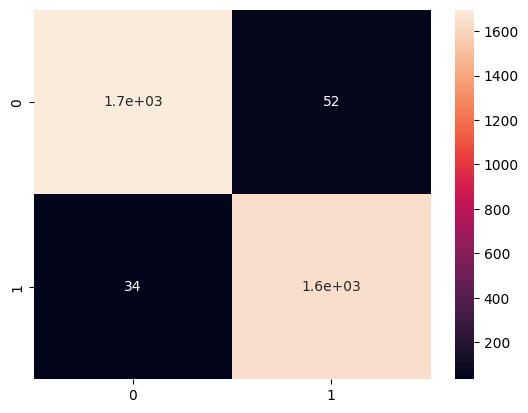

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, clf.predict(X_test), labels=clf.classes_)
sns.heatmap(cm, annot=True)

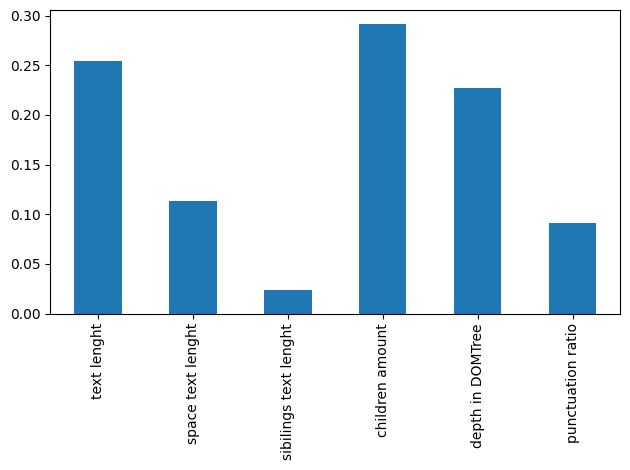

In [23]:
import matplotlib.pyplot as plt 

feature_names = ['text lenght', 'space text lenght', 'sibilings text lenght', 'children amount', 'depth in DOMTree', 'punctuation ratio']
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_names)
fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax, )#yerr=std, )
fig.tight_layout()

<Axes: ylabel='Density'>

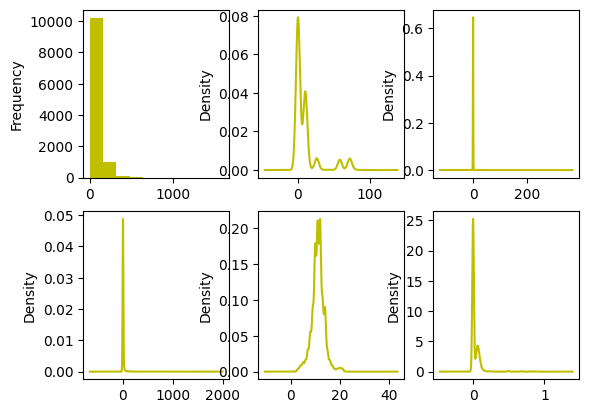

In [113]:
X['y'] = y
plt.subplot(2, 3, 1)
X.f1.plot(kind='hist', color='y')
plt.subplot(2, 3, 2)
X.f2.plot(kind='kde', color='y')
plt.subplot(2, 3, 3)
X.f3.plot(kind='kde', color='y')
plt.subplot(2, 3, 4)
X.f4.plot(kind='kde', color='y')
plt.subplot(2, 3, 5)
X.f5.plot(kind='kde', color='y')
plt.subplot(2, 3, 6)
X.f6.plot(kind='kde', color='y')

In [72]:
text_elems = list(map(lambda x: (x.text).replace('\u200c', ' ')
                           .replace('  ', ' ')
                           .replace('\t', ' ')
                           .replace('.', '')
                           .replace(',', '')
                        #    .replace('و', '')
                        #    .replace('از', '')
                        #    .replace('به', '')
                        #    .replace('با', '')
                        #    .replace('که', '')
                        #    .replace('تا', '')
                        #    .replace('در', '')
                        #    .replace('های', '')
                           .replace('\u202c', ' '), text))
text_elems = ' '.join(text_elems)


In [73]:
elems = [htmls[i].find_all(["div", 'span', 'p', 'article', 
                                    *[f'h{i}' for i in range(1, 7)]])
                    for i in range(len(htmls))]
#target_elements
elems = list(filter(lambda x: x!=[], elems))
elems = [i[0] for i in elems]


text_elems2 = list(map(lambda x: (x.text).replace('\u200c', ' ')
                           .replace('  ', ' ')
                           .replace('\t', ' ')
                           .replace('.', '')
                           .replace(',', '')
                        #    .replace('و', '')
                        #    .replace('از', '')
                        #    .replace('به', '')
                        #    .replace('با', '')
                        #    .replace('که', '')
                        #    .replace('تا', '')
                        #    .replace('در', '')
                        #    .replace('های', '')
                           .replace('\u202c', ' '), elems))
text_elems2 = ' '.join(text_elems2)

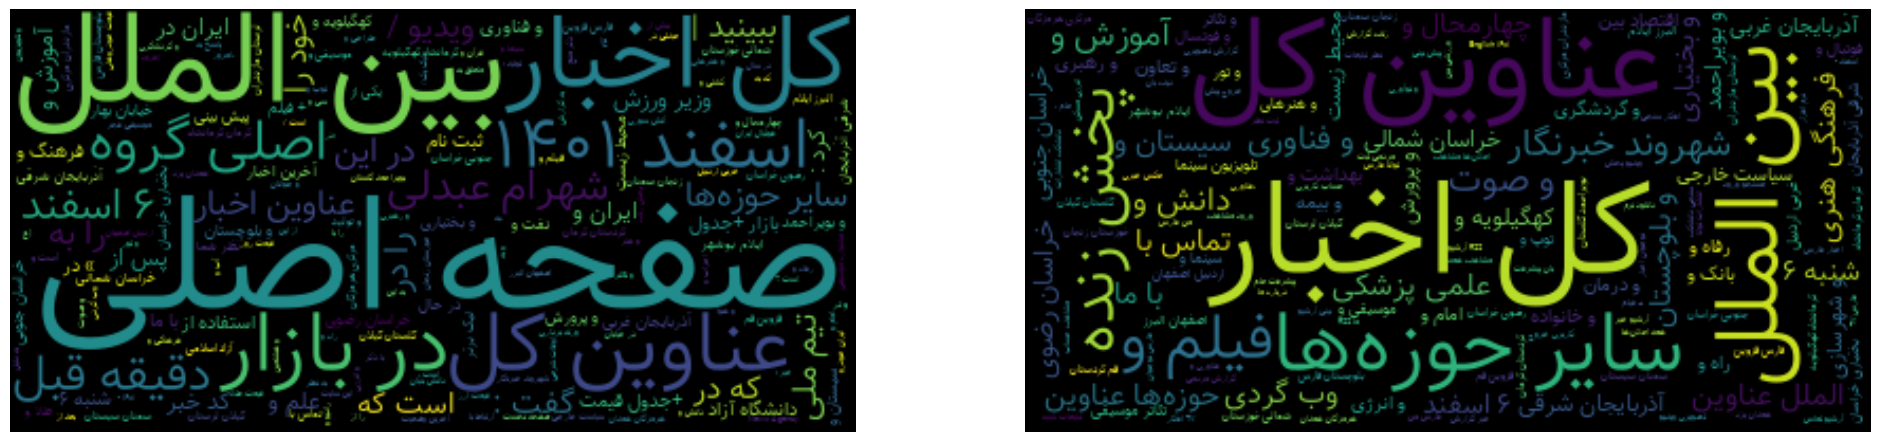

In [74]:
from wordcloud_fa import WordCloudFa

plt.figure(figsize=(24, 16))
plt.subplot(1, 2, 1)
text = target_elements
wordcloud = WordCloudFa(persian_normalize=False).generate(text_elems)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

plt.subplot(1, 2, 2)
text = htmls
wordcloud = WordCloudFa(persian_normalize=False).generate(text_elems2)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

plt.show()

In [110]:
import requests


# url = 'https://www.msn.com/en-ae/news/other/how-china-interacts-with-ukraine-war-will-determine-eu-ties/ar-AA19gXsG?ocid=msedgntp&cvid=ae40389b81ae41f69ffc42bad6f94dde&ei=15'
url = 'https://labsnet.ir/news/69805/%D8%AF%D8%B3%D8%AA%D8%A7%D9%88%D8%B1%D8%AF%D9%87%D8%A7%DB%8C-%D9%81%D9%86%D8%A7%D9%88%D8%B1%D8%A7%D9%86%D9%87-%D8%AF%D8%B1-%D8%AD%D9%88%D8%B2%D9%87-%D8%AA%D8%AC%D9%87%DB%8C%D8%B2%D8%A7%D8%AA-%D9%88-%D9%85%D9%88%D8%A7%D8%AF-%D8%A2%D8%B2%D9%85%D8%A7%DB%8C%D8%B4%DA%AF%D8%A7%D9%87%DB%8C'
req = requests.get(url)
soup_test = BeautifulSoup(req.content, 'html.parser')
elems_test = soup_test.find_all(["div", 'span', 'p', *[f'h{i}' for i in range(1, 7)]])[2:]
df_test = create_feature_space(elems_test)
preds = clf.predict(df_test)


In [112]:
for i in range(len(preds)): 
    if preds[i] == 1:
        print(elems_test[i])

<h1>دستاوردهای فناورانه در حوزه تجهیزات و مواد آزمایشگاهی</h1>
<p>نمایشگاه تجهیزات و مواد آزمایشگاهی ایران‌ساخت با هدف معرفی توانمندی‌های فناورانه در حوزه آزمایشگاهی برگزار می‌شود.</p>
<p style="text-align:justify;">بخش غیر قابل اجتناب و حیاتی در کارآمدی پژوهش‌ها، تحقیق و توسعه، ارزیابی کیفی محصولات و ارتقای تولید آزمایش‌ها هستند. انجام آزمایشات دقیق و کارآمد مستلزم بهره‌مندی از تجهیزات آزمایشگاهی، مواد مصرفی و مواد مرجع می باشد که شرکت‌های دانش‌بنیان با توجه به اهمیت و ضرورت بومی سازی این مواد و تجهیزات، چند سالی است که در مسیر بومی‌سازی، تولید و توسعه آن‌ها گام برداشته‌اند.</p>
<p style="text-align:justify;">معاونت علمی، فناوری و اقتصاد دانش‌بنیان ریاست جمهوری با توجه به اهمیت بالا و نقش راهبردی تجهیزات و مواد آزمایشگاهی، از شرکت‌های دانش‌بنیان و فناور که در مسیر تولید و تجاری‌سازی این محصولات گام بردارند حمایت می‌کند. از سوی دیگر، مراکز تحقیقاتی، پژوهشی و فناور که نیاز مبرمی به این تجهیزات و مواد آزمایشگاهی دارند، ‌باید از حمایت‌های لازم برای بهره‌مندی و استفاده از این تجهیزات و موا